In [1]:
# LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import TargetEncoder

import sys

sys.path.append('../src')

from utils import format_decimals


sns.set_theme(style="darkgrid")

LITTLE_CONSTANT_LOG_10_TRANSFORM = 0.001

In [2]:
pd.options.display.width = 0
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',500)

df = pd.read_csv('./../datasets/electronic_products_cleaned_dataset.csv')

temp_df = pd.DataFrame((df.isnull().sum()/df.shape[0])*100,columns=['Null value%'])
temp_df['data_type'] = df.dtypes
temp_df.T

,id,Actual_price,Discount_price,Product_availability,Condition,Currency,Country,isSale,merchant,brand,Description,Category_name,primaryCategories,name,weight_in_kg,Impression,Day,Month,Year,Week,Month_Name,Day_Name,Formatted_date,Disc_Per,Total_sale
Null value%,0.0,0.0,0.0,1.6693,9.569279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.45339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
data_type,object,float64,float64,object,object,object,object,bool,object,object,object,object,object,object,float64,int64,int64,int64,int64,int64,object,object,object,float64,float64


In [3]:
# OBTENER UN DATASET REDUCIDO

# Obtener la proporción original de productos por categoría
original_proportion = df['Category_name'].value_counts(normalize=True)

# Determinar la proporción deseada para la muestra reducida (por ejemplo, 2%)
sample_proportion = 0.007

# # Calcular el tamaño de muestra para cada categoría
samples_size = (original_proportion * sample_proportion * len(df)).astype(int)

# # Realizar muestreo estratificado
reduced_df = df.groupby('Category_name', group_keys=False).apply(lambda x: x.sample(samples_size[x.name]))

reduced_df = reduced_df.reset_index(drop=True)

# reduced_df ahora contiene el 2% de productos de cada categoría con proporciones iguales al conjunto original

# Asignar dataframe reducido al dataframe original para determinar su distribución
df = reduced_df


In [4]:
# Eliminar columnas no necesarias
df.drop(columns=['Discount_price', 'isSale',
                 'merchant', 'Impression', 'Day',
                 'Month', 'Year', 'Week', 'Month_Name', 'Day_Name',
                 'Formatted_date', 'Disc_Per', 'Total_sale'], inplace=True)

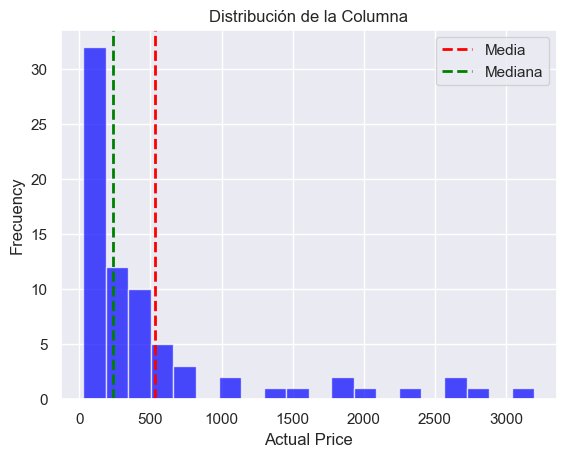

In [5]:
# Calcular estadísticas descriptivas para la columna "Actual_price" con sesgo positivo

actual_price = df['Actual_price']
mean = actual_price.mean()
median = actual_price.median()

# Agregar líneas verticales para las estadísticas descriptivas
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label='Media')
plt.axvline(median, color='green', linestyle='dashed', linewidth=2, label='Mediana')
plt.legend()

plt.hist(df['Actual_price'], bins=20, color='blue', alpha=0.7)
plt.title('Distribución de la Columna')
plt.xlabel('Actual Price')
plt.ylabel('Frecuency')
plt.show()

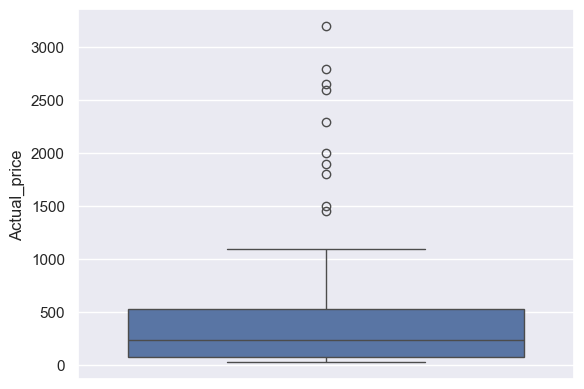

In [6]:
# Detectar los valores outliers en la columna Actual_price
sns.boxplot(df['Actual_price'])

percentile25 = df['Actual_price'].quantile(0.25)
percentile75 = df['Actual_price'].quantile(0.75)

iqr = percentile75 - percentile25

upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

outliers = df[(df['Actual_price'] < lower_limit) | (df['Actual_price'] > upper_limit)]

# Eliminar los productos con precios considerados como valores outliers
df = df.drop(outliers.index)

(64, 12)


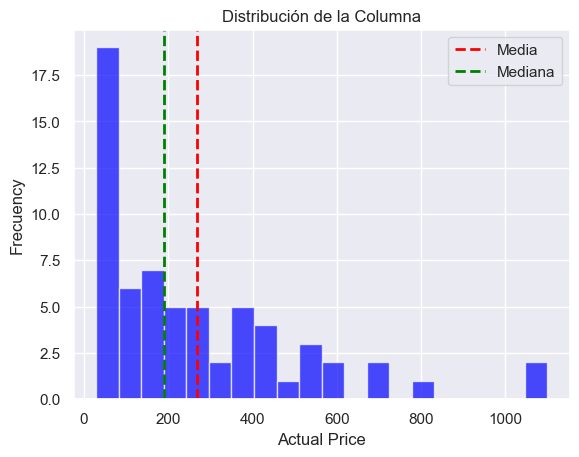

In [7]:
# Calcular estadísticas descriptivas para la columna "Actual_price" despues de eliminar los valores outliers
print(df.shape)
actual_price = df['Actual_price']
mean = actual_price.mean()
median = actual_price.median()

# Agregar líneas verticales para las estadísticas descriptivas
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label='Media')
plt.axvline(median, color='green', linestyle='dashed', linewidth=2, label='Mediana')
plt.legend()

plt.hist(df['Actual_price'], bins=20, color='blue', alpha=0.7)
plt.title('Distribución de la Columna')
plt.xlabel('Actual Price')
plt.ylabel('Frecuency')
plt.show()

In [8]:
# APLICAR TRANSFORMACIÓN LOGARITMICA DE BASE 10 SOBRE LA VARIABLE ACTUAL_PRICE PARA NORMALIZAR LA DISTRIBUCIÓN

actual_price_log = np.log1p(df['Actual_price'] + LITTLE_CONSTANT_LOG_10_TRANSFORM).tolist()
actual_price_log = format_decimals(actual_price_log, 4)
df['Actual_price_log'] = actual_price_log

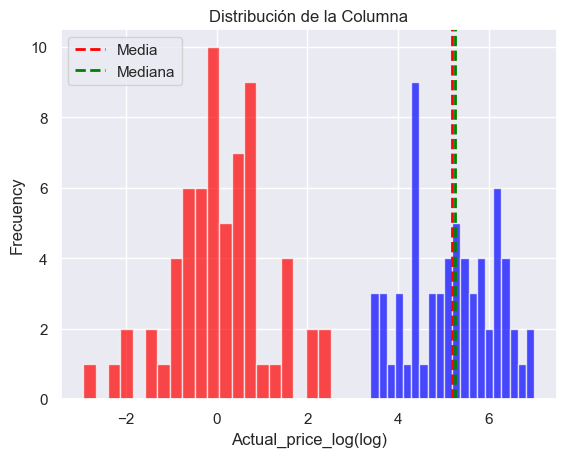

In [9]:
# Calcular estadísticas descriptivas para la columna Actual_price despues de la transformación logaritmica de base 10
actual_price_log = df['Actual_price_log']
actual_price_log_mean = actual_price_log.mean()
actual_price_log_median = actual_price_log.median()

normal_data = np.random.normal(size=len(df['Actual_price_log']))

# Agregar líneas verticales para las estadísticas descriptivas
plt.axvline(actual_price_log_mean, color='red', linestyle='dashed', linewidth=2, label='Media')
plt.axvline(actual_price_log_median, color='green', linestyle='dashed', linewidth=2, label='Mediana')
plt.legend()

plt.hist(df['Actual_price_log'], bins=20, color='blue', alpha=0.7, label='Datos transformados')
plt.hist(normal_data, bins=20, color='red', alpha=0.7, label='Distribución normal')
plt.title('Distribución de la Columna')
plt.xlabel('Actual_price_log(log)')
plt.ylabel('Frecuency')
plt.show()

In [10]:
# Estandarizar la columna brand

brands_serie = df['brand']

# Estandarizo todas las marcas a minuscula
brands_serie = brands_serie.str.lower()

# Unifico las marcas duplicadas que estan escritas de distinta manera
brands_serie.replace({': polk audio': 'polk audio',
                'belkin inc.': 'belkin',
                'bose®': 'bose',
                'buffalo technology': 'buffalo',
                'cerwin vega': 'cerwin-vega',
                'cobra electronics': 'cobra',
                'denon - heos': 'denon',
                'insignia™': 'insignia',
                'jvcm': 'jvc',
                'kanto': 'kanto living',
                'klipsch xr8i in-ear headphones': 'klipsch',
                'master dynamic': 'master & dynamic',
               'motorola home': 'motorola', 
                'mtx audio': 'mtx',
                'panamx': 'panamax', 
                'pro-ject': 'pro-ject audio systems',
                'pyle pro': 'pyle', 'pylehome': 'pyle',
                'startech.com': 'startech', 'vizio, inc': 'vizio'
        }, inplace=True)

# # Anexo la serie en el dataframe original
df['brand_standarized'] = brands_serie

C:\Users\fabia\AppData\Local\Temp\ipykernel_9444\4125908084.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax[1] = sns.countplot(x="Category_name", data=df, palette="Set1")


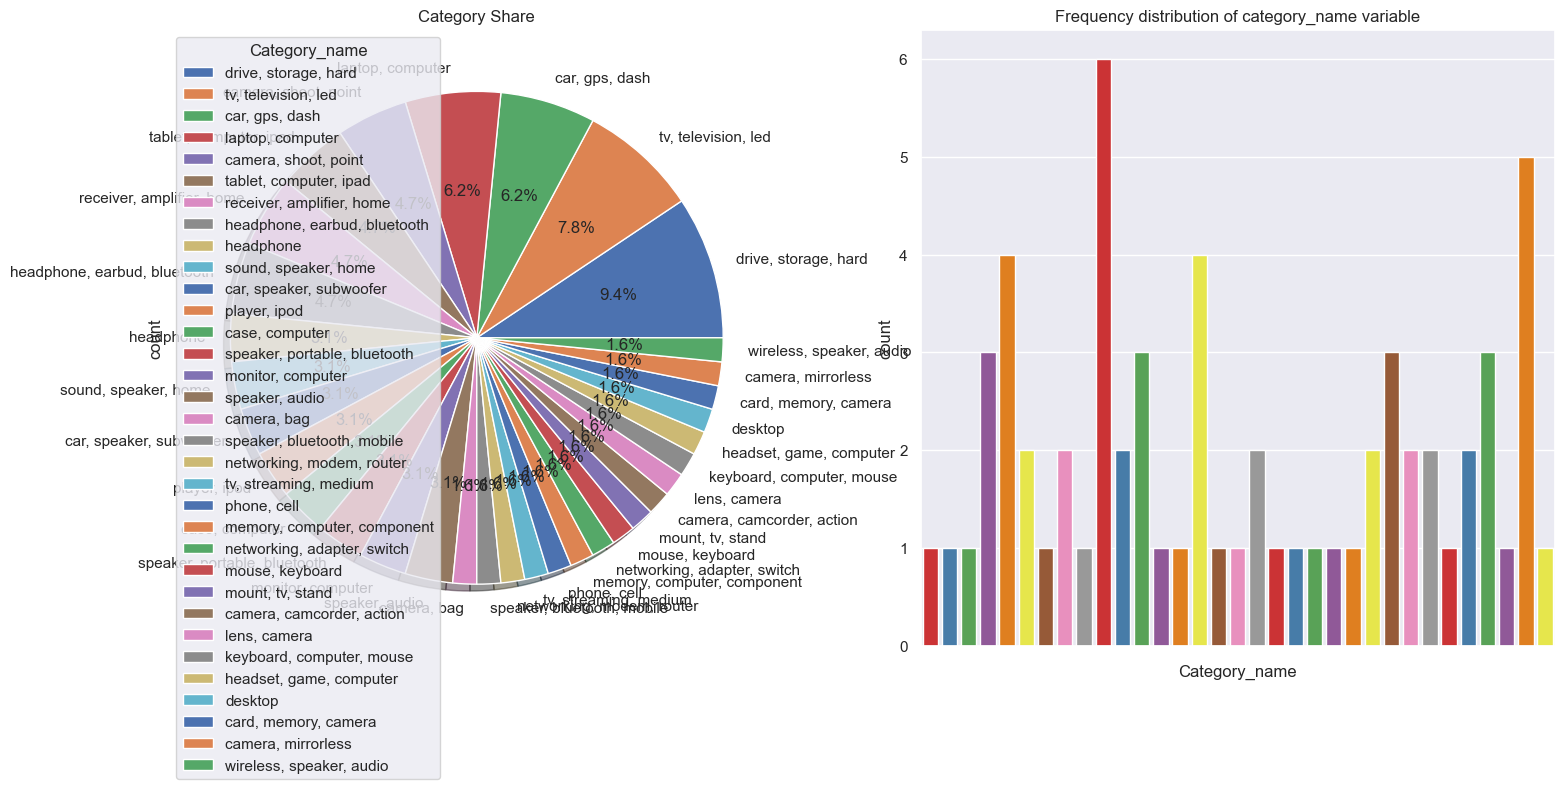

In [11]:
f,ax=plt.subplots(1,2,figsize=(18,8))

categories = df['Category_name'].value_counts()
explode = [0]*len(categories)

ax[0] = df['Category_name'].value_counts().plot.pie(explode=explode,autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Category Share')
# Leyenda para el gráfico de pastel
ax[0].legend(title="Category_name")


#f, ax = plt.subplots(figsize=(6, 8))
ax[1] = sns.countplot(x="Category_name", data=df, palette="Set1")
ax[1].set_title("Frequency distribution of category_name variable")
ax[1].set_xticklabels([])  # elimina las etiquetas del eje x

plt.show()

In [12]:
# Transformar la columna cualitativa "Category_name" a continua

#1) Obtengo el precio promedio por Categoria
actual_price_mean_grouped_by_category_name = df.groupby("Category_name")["Actual_price"].mean().reset_index()
actual_price_mean_grouped_by_category_name.columns = ['Category_name', 'Actual_price_mean_by_category_name']

actual_price_meand_by_category_serie = actual_price_mean_grouped_by_category_name['Actual_price_mean_by_category_name']
actual_price_meand_by_category_serie = format_decimals(actual_price_meand_by_category_serie, 4)
actual_price_mean_grouped_by_category_name['Actual_price_mean_by_category_name'] = actual_price_meand_by_category_serie

df = pd.merge(df, actual_price_mean_grouped_by_category_name, on='Category_name', how='left')

In [13]:
# 2) ENCODING Category_name COLUMN USING K-FOLD TARGET ENCODING

category_name = df['Category_name'].to_numpy().reshape(-1, 1)
actual_price_mean_grouped_by_category = df['Actual_price_mean_by_category_name'].to_numpy()

# Agregar algo de ruido para evitar codificaciones exactas, esto es util cuando hay valores iguales en la
# variable target
actual_price_mean_grouped_by_category_noisy = actual_price_mean_grouped_by_category + np.random.normal(0, 0.01, size=actual_price_mean_grouped_by_category.size)

# Crear una columna temporal para almacenar las codificaciones k-fold
df['Category_name_encoded'] = 0.0

te = TargetEncoder(target_type="continuous", smooth=2.0, shuffle=False)
te.fit_transform(category_name, actual_price_mean_grouped_by_category_noisy)
category_name_encoded = te.transform(category_name)

df['Category_name_encoded'] = category_name_encoded[:, 0]

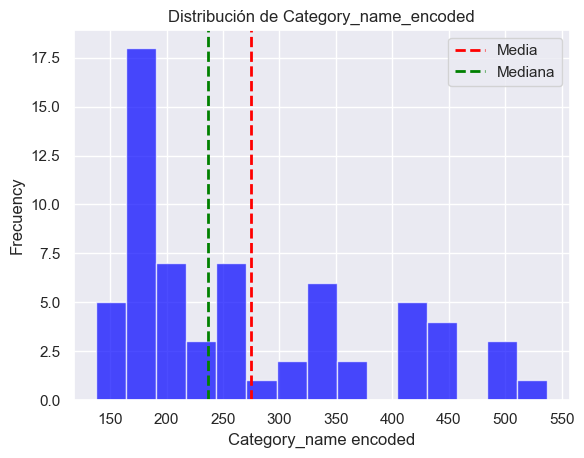

In [14]:
category_name_encoded = df['Category_name_encoded']
category_name_encoded_mean = category_name_encoded.mean()
category_name_encoded_median = category_name_encoded.median()

# Agregar líneas verticales para las estadísticas descriptivas
plt.axvline(category_name_encoded_mean, color='red', linestyle='dashed', linewidth=2, label='Media')
plt.axvline(category_name_encoded_median, color='green', linestyle='dashed', linewidth=2, label='Mediana')
plt.legend()

plt.hist(category_name_encoded, bins=15, color='blue', alpha=0.7, label='Category_name_encoded')
plt.title('Distribución de Category_name_encoded')
plt.xlabel('Category_name encoded')
plt.ylabel('Frecuency')
plt.show()

In [15]:
# Dado al sesgo positivo, aplico transformación logaritmica para suavizar la cola derecha
df['Category_name_encoded_log'] = np.log1p(df['Category_name_encoded'] + LITTLE_CONSTANT_LOG_10_TRANSFORM).tolist()
category_name_encoded_log = df['Category_name_encoded_log']
category_name_encoded_log = format_decimals(category_name_encoded_log, 4)
df['Category_name_encoded_log'] = category_name_encoded_log

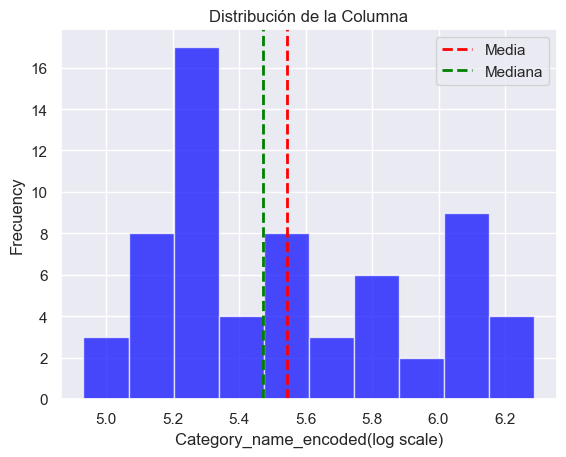

In [16]:
# Calcular estadísticas descriptivas para la categoria codificada
category_name_encoded_log = df['Category_name_encoded_log']
category_name_encoded_mean = category_name_encoded_log.mean()
category_name_encoded_median = category_name_encoded_log.median()

# Agregar líneas verticales para las estadísticas descriptivas
plt.axvline(category_name_encoded_mean, color='red', linestyle='dashed', linewidth=2, label='Media')
plt.axvline(category_name_encoded_median, color='green', linestyle='dashed', linewidth=2, label='Mediana')
plt.legend()

plt.hist(category_name_encoded_log, bins=10, color='blue', alpha=0.7, label='Category name encoded')
plt.title('Distribución de la Columna')
plt.xlabel('Category_name_encoded(log scale)')
plt.ylabel('Frecuency')
plt.show()


In [17]:
# Replace id column by row index
df.drop(columns=['id'], inplace=True)
df.reset_index(inplace=True)
df = df.rename(columns={"index": 'id'})

In [18]:
# Guardar en archivo csv 
df.to_csv('./../datasets/reduced_electronic_products.csv', index = False) 